In [19]:
#importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim

In [20]:
#uploading data
df = pd.read_csv("/kaggle/input/wine-quality-dataset/winequality-red.csv", sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [22]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [23]:
df['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

Here, the data is highly imbalanced, but as i didn't deal with imbalanced data in the previous task and now i have to compare the accuracy with the previous task that was done with neural network model built from scratch using numpy and python.

In [24]:
# Separate features and target
X = df.drop('quality', axis=1).values
y = df['quality']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [25]:
y_array = y.to_numpy().reshape(-1, 1)

In [26]:
# One-hot encode the target variable
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y_array)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


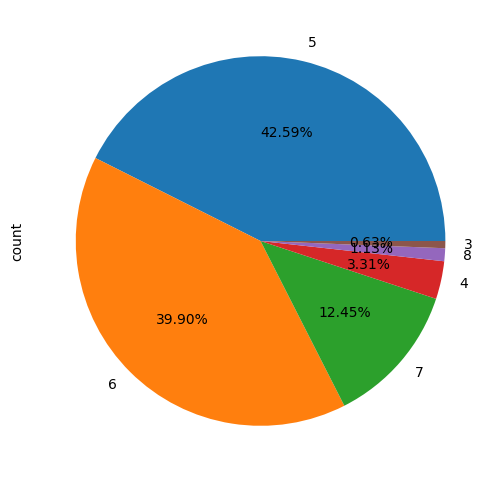

In [27]:
plt.figure(figsize=(6, 6))
df['quality'].value_counts().plot.pie(autopct="%1.2f%%")
plt.show()

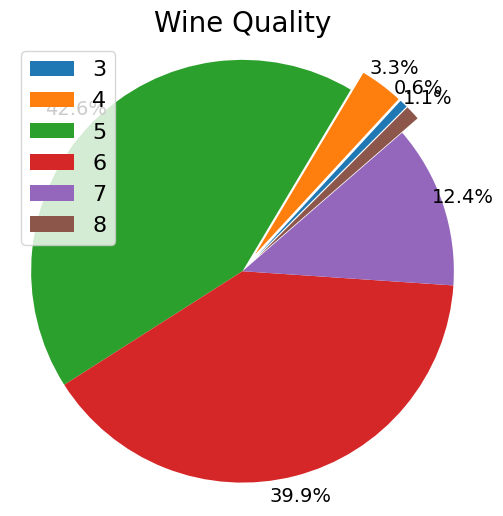

In [28]:
quality = df["quality"].value_counts().sort_index(ascending=True)
explode_list = [0.1, 0.1, 0, 0, 0, 0.1]
ax = quality.plot(kind='pie',
             figsize = (6,6),
             autopct='%1.1f%%', 
             startangle=45,
             labels=None,         
             pctdistance=1.1,    
             explode=explode_list,
             textprops={'fontsize': 14})
ax.patch.set_facecolor('white')
plt.title('Wine Quality', size = 20)
ax.set(ylabel=None)
plt.axis('equal') 
plt.legend(labels=quality.index, loc="upper left", fontsize=16);

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, y_onehot,
                                                    test_size = 0.3,
                                                    shuffle = True,
                                                    random_state = 1)

In [30]:
class LLayerNeuralNetwork(nn.Module):
    def __init__(self, layers_dims):
        super(LLayerNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        L = len(layers_dims)
        for l in range(1, L):
            self.layers.append(nn.Linear(layers_dims[l-1], layers_dims[l]))
            self.layers.append(nn.BatchNorm1d(layers_dims[l]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.5))
        self.layers = self.layers[:-2]  # Remove last ReLU and Dropout for output layer
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [31]:
def compute_cost(AL, Y):
    criterion = nn.BCEWithLogitsLoss()
    cost = criterion(AL, Y)
    return cost

In [32]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    torch.manual_seed(1)
    model = LLayerNeuralNetwork(layers_dims)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    costs = []
    for i in range(num_iterations):
        model.train()
        AL = model(X)
        cost = compute_cost(AL, Y)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        if print_cost and i % 1000 == 0:
            print(f"Cost after iteration {i}: {cost.item()}")
            costs.append(cost.item())
    return model, costs

In [33]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predictions = torch.max(outputs, 1)
    return predictions

In [34]:
def compute_accuracy(predictions, Y):
    return (predictions == Y).float().mean().item()

In [35]:
# Convert pandas DataFrames to NumPy arrays
x_train_np = x_train
x_test_np = x_test
y_train_np = y_train  
y_test_np = y_test


# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(x_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

In [36]:
y_train_tensor.shape

torch.Size([1119, 6])

In [37]:
output_units = y_train_tensor.shape[1]  # Number of output units should match the number of classes
layers_dims = [X_train_tensor.shape[1], 25,10,  output_units]  # Adjust based on y_train_tensor

In [38]:
model, costs = L_layer_model(X_train_tensor, y_train_tensor, layers_dims, learning_rate=0.001, num_iterations=10000, print_cost=True)

Cost after iteration 0: 0.7928979396820068
Cost after iteration 1000: 0.444927841424942
Cost after iteration 2000: 0.3519578278064728
Cost after iteration 3000: 0.3065253496170044
Cost after iteration 4000: 0.29071271419525146
Cost after iteration 5000: 0.2839965522289276
Cost after iteration 6000: 0.2759588360786438
Cost after iteration 7000: 0.27037736773490906
Cost after iteration 8000: 0.2734229564666748
Cost after iteration 9000: 0.27179497480392456


In [525]:
# Evaluate the model
model.eval()
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    test_outputs = model(X_test_tensor)

In [526]:
train_predictions = torch.argmax(train_outputs, axis=1)
test_predictions = torch.argmax(test_outputs, axis=1)

In [527]:
# Convert one-hot encoded labels to class indices
train_labels = torch.argmax(y_train_tensor, axis=1)
test_labels = torch.argmax(y_test_tensor, axis=1)

In [528]:
train_accuracy = compute_accuracy(train_predictions, train_labels)
test_accuracy = compute_accuracy(test_predictions, test_labels)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 66.93%
Test Accuracy: 63.13%


Almost same accuracy that i had achieved in the previous week.

Now , can i improve it?....let's give it a try..

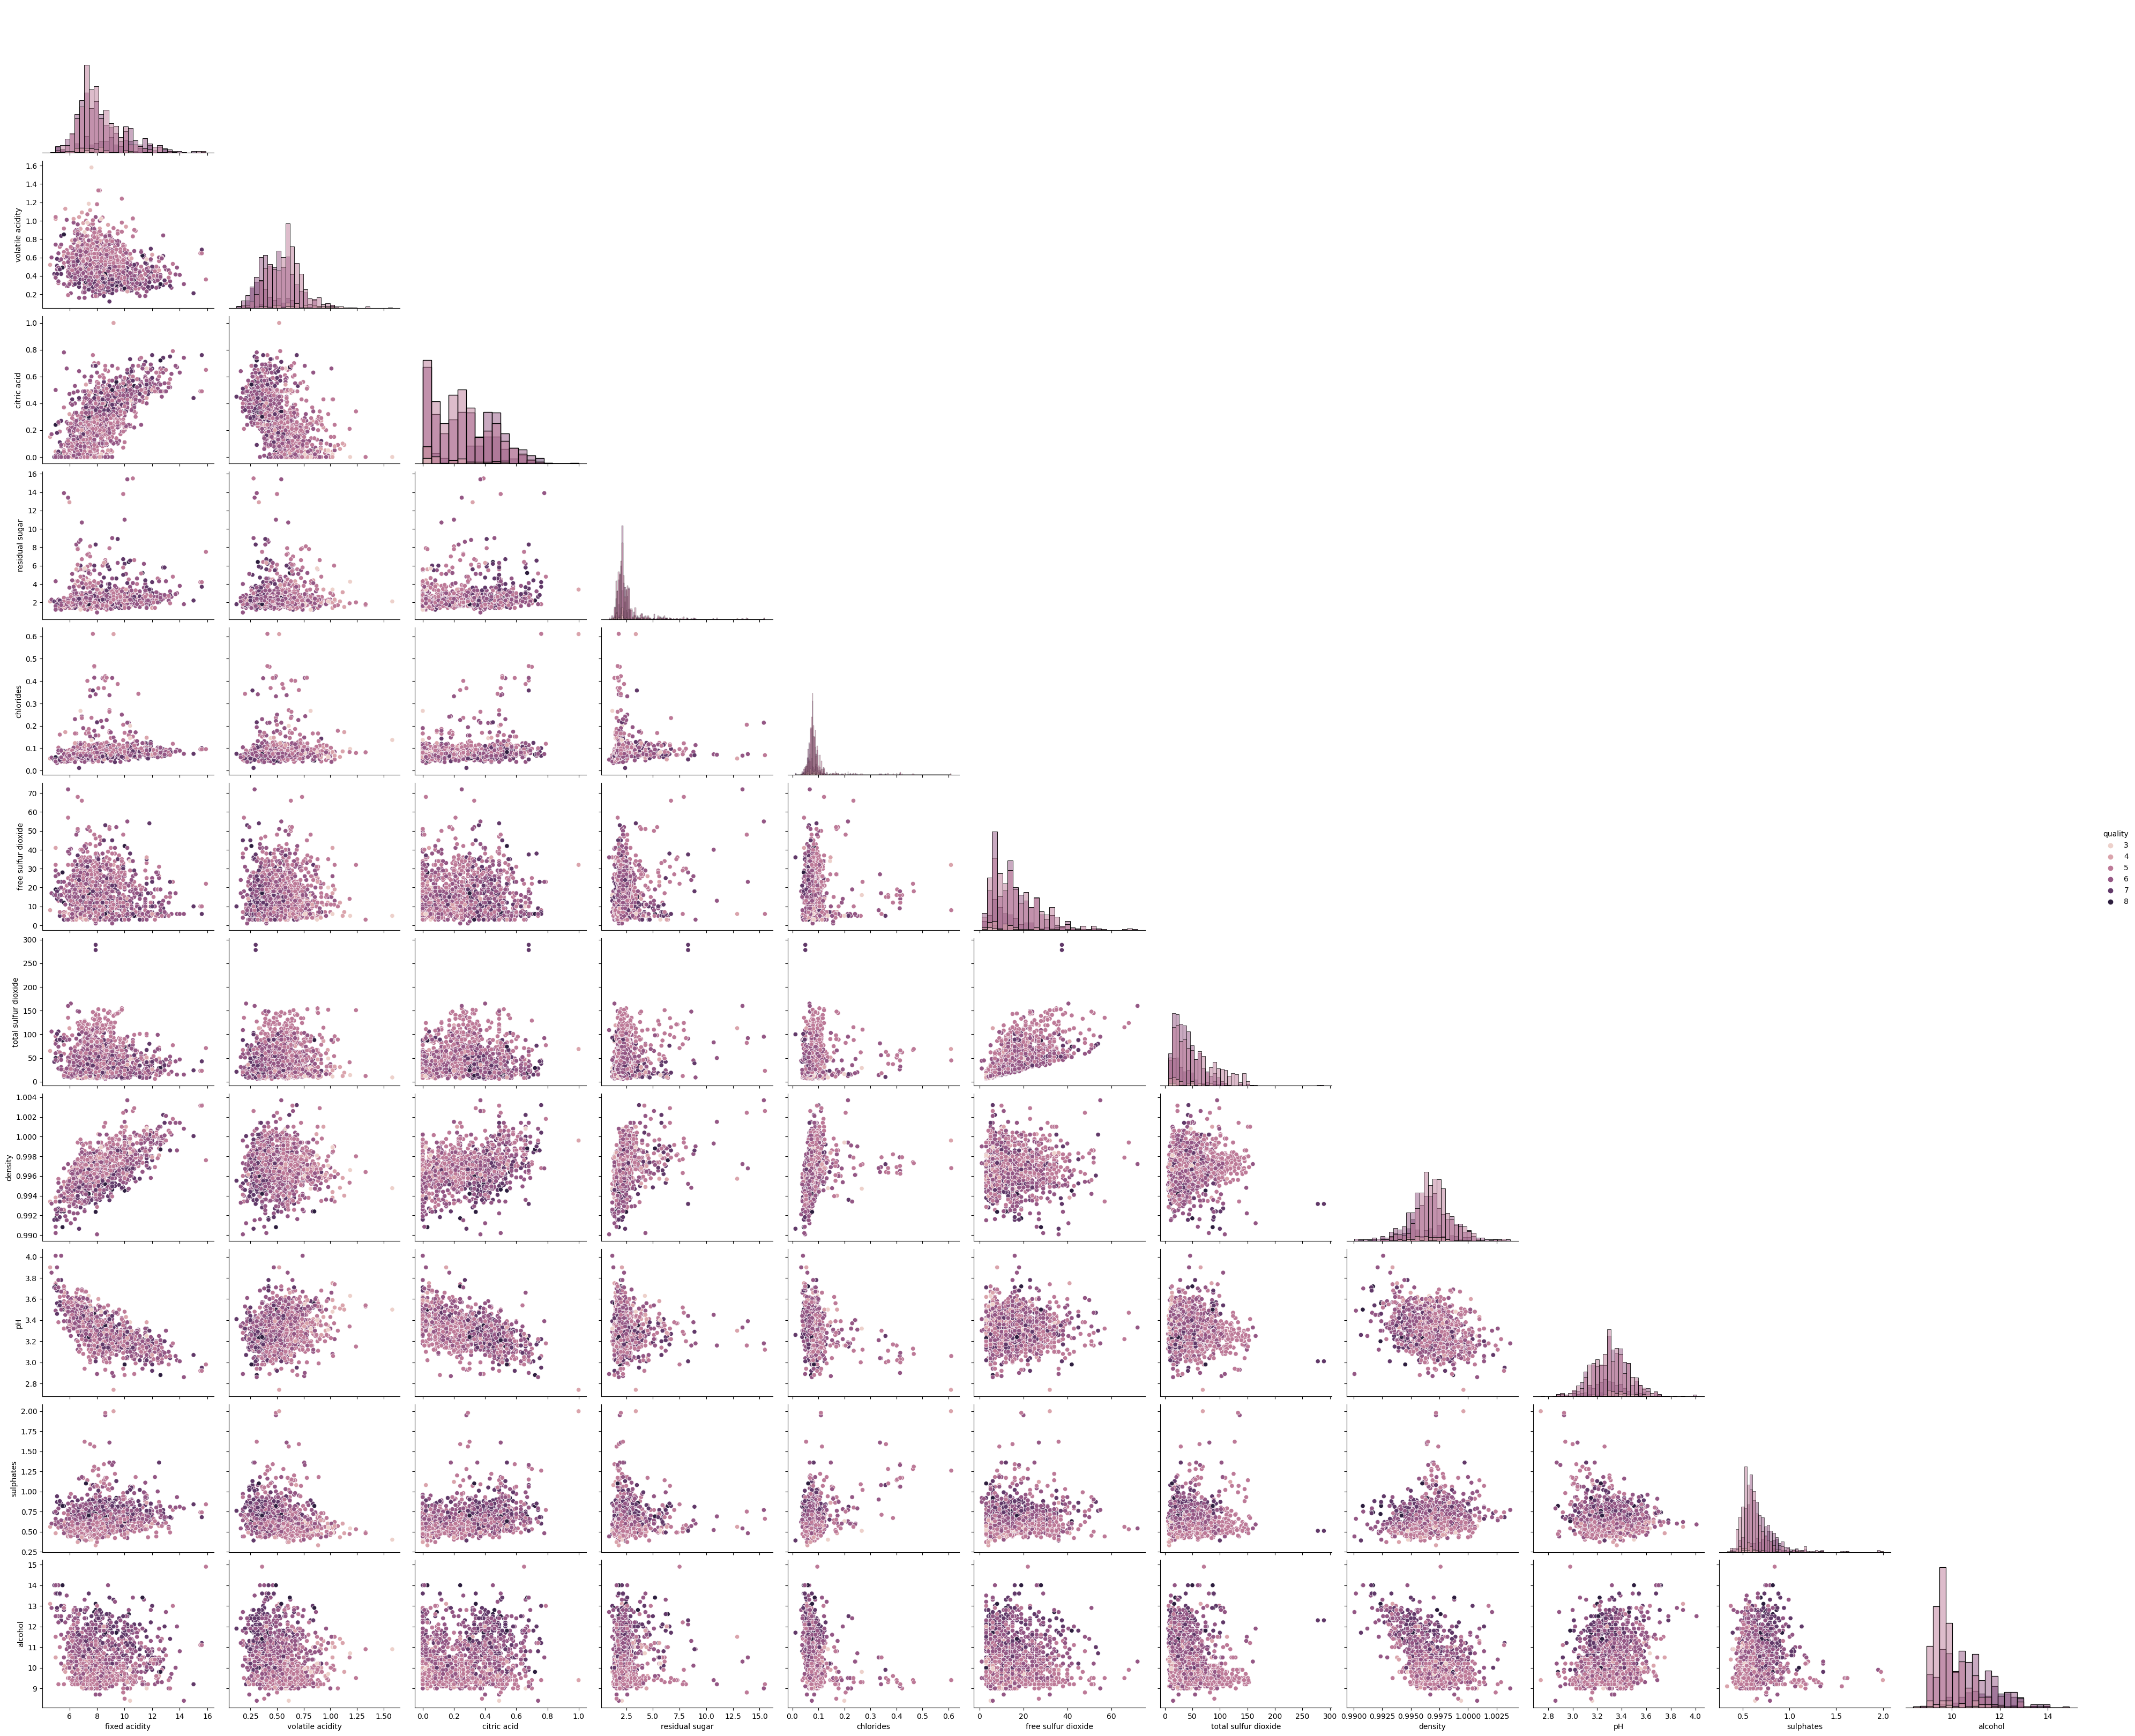

In [39]:
import warnings
warnings.filterwarnings('ignore')
sns.pairplot(df, diag_kind = "hist", hue = "quality", height = 3, aspect = 1.2, corner = True);

We can see that some features are correlated.i.e.multicollinearity exists.

<Axes: >

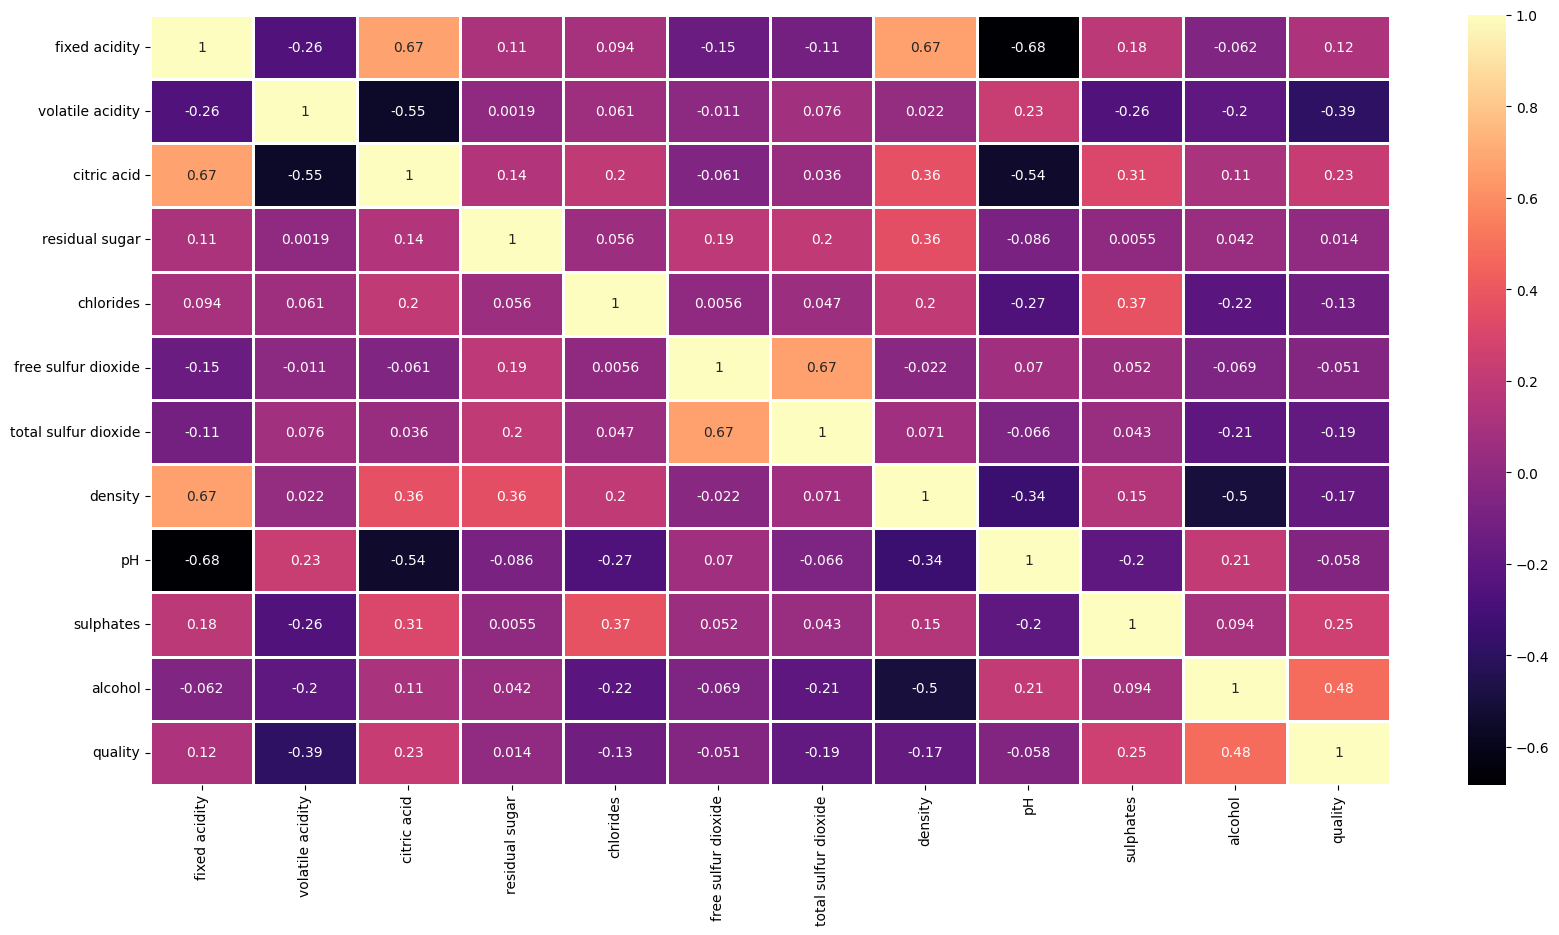

In [40]:
plt.figure(figsize = [20, 10], facecolor = 'white')
sns.heatmap(df.corr(), annot = True, linewidths = 2, cmap = "magma")

In [41]:
list = (df[["alcohol","density"]].corr(), df[["fixed acidity","pH"]].corr(),
        df[["citric acid","pH"]].corr(), df[["fixed acidity","density"]].corr(),
        df[["free sulfur dioxide","total sulfur dioxide"]].corr())
for corr in list:
    print(corr, "\n\n")

         alcohol  density
alcohol  1.00000 -0.49618
density -0.49618  1.00000 


               fixed acidity        pH
fixed acidity       1.000000 -0.682978
pH                 -0.682978  1.000000 


             citric acid        pH
citric acid     1.000000 -0.541904
pH             -0.541904  1.000000 


               fixed acidity   density
fixed acidity       1.000000  0.668047
density             0.668047  1.000000 


                      free sulfur dioxide  total sulfur dioxide
free sulfur dioxide              1.000000              0.667666
total sulfur dioxide             0.667666              1.000000 




- Alcohol and Density: Moderately negative correlation (-0.496).
- Fixed Acidity and pH: Strongly negative correlation (-0.683).
- Citric Acid and pH: Moderately negative correlation (-0.542).
- Fixed Acidity and Density: Moderately positive correlation (0.668).
- Free Sulfur Dioxide and Total Sulfur Dioxide: Strongly positive correlation (0.668).

In [42]:
#df['fixed_acidity_pH'] = df['fixed acidity'] * df['pH']
#df['fixed_acidity_density'] = df['fixed acidity'] * df['density']
#df['free_total_sulfur_dioxide'] = df['free sulfur dioxide'] + df['total sulfur dioxide']

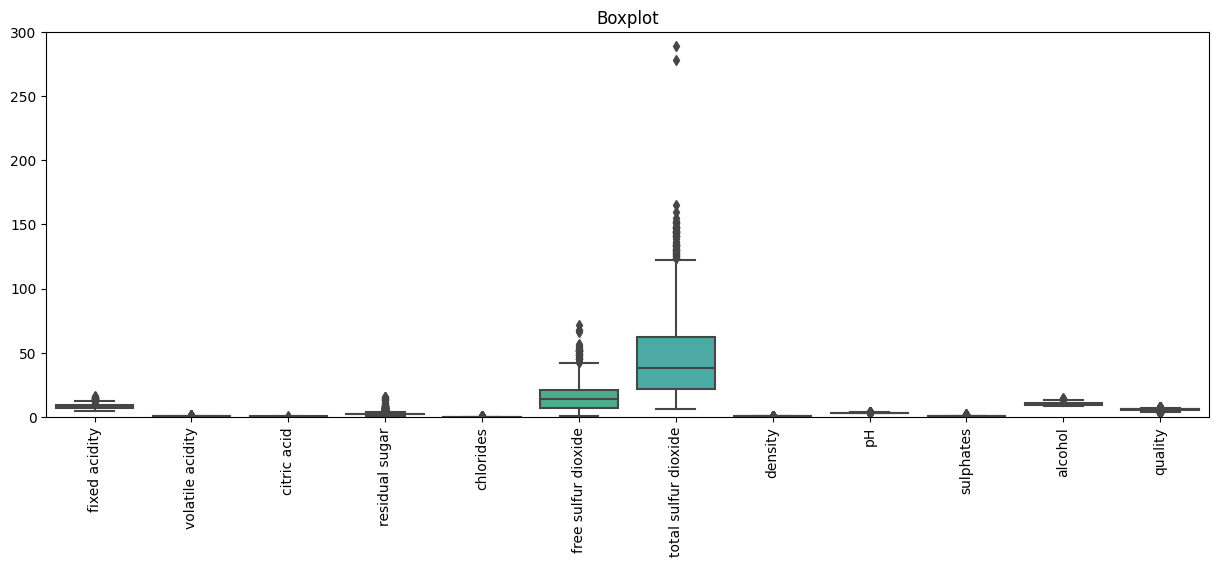

In [43]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df)
plt.title('Boxplot')
plt.ylim([0, 300])
plt.xticks(rotation = 'vertical')
plt.show()

In [44]:
def remove_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [45]:
#df = remove_outliers(df)

In [46]:
df['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

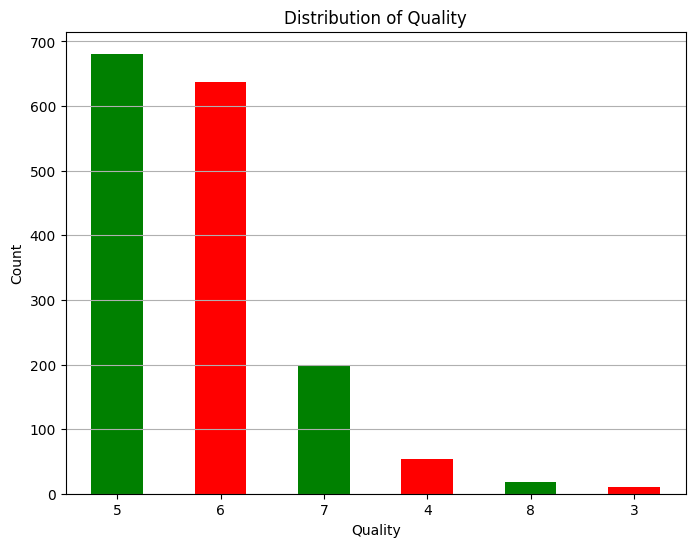

In [47]:
quality_counts = df['quality'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
quality_counts.plot(kind='bar', color=['green', 'red'])  # Color 'green' for 'good', 'red' for 'bad'
plt.title('Distribution of Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Show grid lines on y-axis
plt.show()

Can we do something with this highly imbalanced data?....i have an idea..

In [48]:
df['quality'] = pd.cut(df['quality'], bins=[1, 5, 10], labels=['bad', 'good'])

In [49]:
label_encoder = LabelEncoder()
df['quality'] = label_encoder.fit_transform(df['quality'])
df['quality'].value_counts()

quality
1    855
0    744
Name: count, dtype: int64

In [50]:
scaler = StandardScaler()
features = [features for features in df.columns if df[features].dtype != int]
df[features] = scaler.fit_transform(df[features])
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,0
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,0
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,0
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,1
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217796,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294,0
1595,-1.390155,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364,1
1596,-1.160343,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630,1
1597,-1.390155,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308,0


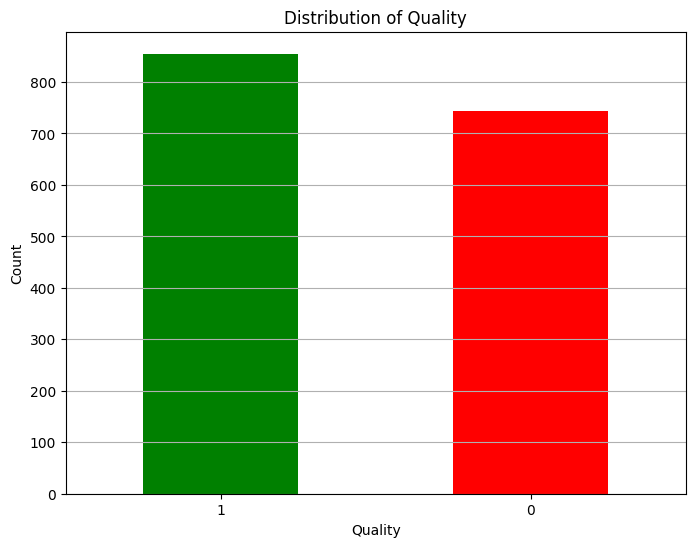

In [63]:
quality_counts = df['quality'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
quality_counts.plot(kind='bar', color=['green', 'red'])  # Color 'green' for 'good', 'red' for 'bad'
plt.title('Distribution of Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Show grid lines on y-axis
plt.show()

In [64]:
X = df.drop('quality', axis = 1)
y = df['quality']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim

In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11, 25)
        self.dropout1 = nn.Dropout(0.3)  # Dropout with 40% probability
        self.fc2 = nn.Linear(25, 10)
        self.dropout2 = nn.Dropout(0.3)  # Dropout with 40% probability
        self.fc3 = nn.Linear(10, 1)  # Output layer with 1 neuron for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after first fully connected layer
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after second fully connected layer
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary classification
        return x

In [68]:
def compute_accuracy(predictions, targets):
    return (predictions == targets).float().mean().item()

In [69]:
def train_model(model, criterion, optimizer, X_train, y_train, num_epochs=1000):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [70]:
def evaluate_model(model, X, y_true):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        predictions = (outputs > 0.5).float()  # Convert logits to binary predictions (0 or 1)
        accuracy = compute_accuracy(predictions, y_true)
    return accuracy

In [71]:
model = Net()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [72]:
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)  # Add extra dimension for single output
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)    # Add extra dimension for single output

In [73]:
train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, num_epochs=20000)

Epoch [1000/20000], Loss: 0.3963
Epoch [2000/20000], Loss: 0.3811
Epoch [3000/20000], Loss: 0.3895
Epoch [4000/20000], Loss: 0.3946
Epoch [5000/20000], Loss: 0.3788
Epoch [6000/20000], Loss: 0.3776
Epoch [7000/20000], Loss: 0.3699
Epoch [8000/20000], Loss: 0.3741
Epoch [9000/20000], Loss: 0.3667
Epoch [10000/20000], Loss: 0.3598
Epoch [11000/20000], Loss: 0.3872
Epoch [12000/20000], Loss: 0.3698
Epoch [13000/20000], Loss: 0.3697
Epoch [14000/20000], Loss: 0.3793
Epoch [15000/20000], Loss: 0.3569
Epoch [16000/20000], Loss: 0.3942
Epoch [17000/20000], Loss: 0.3473
Epoch [18000/20000], Loss: 0.3598
Epoch [19000/20000], Loss: 0.3906
Epoch [20000/20000], Loss: 0.3770


In [74]:
train_accuracy = evaluate_model(model, X_train_tensor, y_train_tensor)
test_accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 88.58%
Test Accuracy: 81.56%


Improved!!🥳

## Thank you so much for coming to the end of this notebook.